<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/colab_notebooks_for_atmos_sci/blob/main/Two%20Layer%20QG%20Rossby%20Wave%20Model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

This notebook implements a two-layer quasigeostrophic (QG) model, with an initial condition that is either barotropically or baroclinically unstable.

## Objectives

* Run and modify a simple model of midlatitude weather
* Compare results (wavelength, wave speed, structure, etc.) to linear QG theory

## Getting started
Run the cells below.  Play around with the model parameters to see the effects of things like:

* Stability (`nsquar`)
* Shear (`prop_shear`)
* Depth (`hbar`)
* The initial conditions
* Other things!

> **Note**: If you are using this notebook as part of a class assignment, follow the instructions in the assignment rather than those here!

## Model definition
The cells that follow define the model.  They aren't really necessary to play around with for beginners; they just define the QG model. You can just run these cells and forget about them.

In [ ]:
""" Install packages in a special way if in Google Colab. """
# ******************************************************************************
# NOTE: the following code is overly complicated because we are using Google 
# Colab, which does not have some of the packages we want installed.
# If you are running this in your own conda environment, these things install
# simply - this step isn't necessary.
# ******************************************************************************
# check if we are in google colab
# (skip everything in this cell if not)
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


if IN_COLAB:

  # upgrade pip to avoid pip auto-updating packages that don't need updating
  ! pip install --upgrade pip

  try:
    import cftime
  except ImportError:
    ! pip install cftime
  
  try:
    import shtns
  except ImportError:
    # **************
    # install shtns
    # **************
    # this package is used for fast spherical harmonics

    # first install libfftw3-dev
    ! apt-get update && apt-get install libfftw3-dev

    # install shtns
    ! mkdir -p Downloads
    ! cd Downloads \
      && wget https://bitbucket.org/nschaeff/shtns/downloads/shtns-3.5.4.tar.gz \
      && tar -xzf shtns-3.5.3.tar.gz \
      && cd shtns \
      && ./configure --enable-openmp --enable-python \
      && make \
      && python setup.py install

In [1]:
""" Import libraries. """
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import shtns
import os
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
""" Define a wrapper for the shtns library. """

# Credit: the following is based on code from Jeffrey Whitaker
# https://gist.github.com/jswhit/3845307

# turn off multi-threading in numpy; shtns is already multi-threaded
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

class Spharmt(object):
    """
    wrapper class for commonly used spectral transform operations in
    atmospheric models.  Provides an interface to shtns compatible
    with pyspharm (pyspharm.googlecode.com).
    
    This code is taken from 
    https://bitbucket.org/nschaeff/shtns/raw/db6a4a9aeba8c6e235c20ac45db68eb6e0174e0f/examples/shallow_water.py
    """
    def __init__(self, nlons, nlats, ntrunc, rsphere, gridtype="gaussian"):
        """initialize
        nlons:  number of longitudes
        nlats:  number of latitudes"""
        self._shtns = shtns.sht(ntrunc, ntrunc, 1,
                                shtns.sht_orthonormal+shtns.SHT_NO_CS_PHASE)

        if gridtype == "gaussian":
            # self._shtns.set_grid(nlats, nlons,
            #         shtns.sht_gauss_fly | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_quick_init | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
        elif gridtype == "regular":
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_reg_dct | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)

        self.lats = np.arcsin(self._shtns.cos_theta)
        self.lons = (2.*np.pi/nlons)*np.arange(nlons)
        self.nlons = nlons
        self.nlats = nlats
        self.ntrunc = ntrunc
        self.nlm = self._shtns.nlm
        self.degree = self._shtns.l
        self.lap = -self.degree*(self.degree+1.0).astype(np.complex)
        self.invlap = np.zeros(self.lap.shape, self.lap.dtype)
        self.invlap[1:] = 1./self.lap[1:]
        self.rsphere = rsphere
        self.lap = self.lap/rsphere**2
        self.invlap = self.invlap*rsphere**2

    def grdtospec(self, data):
        """compute spectral coefficients from gridded data"""
        return self._shtns.analys(data)

    def spectogrd(self, dataspec):
        """compute gridded data from spectral coefficients"""
        return self._shtns.synth(dataspec)

    def getuv(self, vrtspec, divspec):
        """compute wind vector from spectral coeffs of vorticity and divergence"""
        return self._shtns.synth((self.invlap/self.rsphere)*vrtspec, (self.invlap/self.rsphere)*divspec)

    def getvrtdivspec(self, u, v):
        """compute spectral coeffs of vorticity and divergence from wind vector"""
        vrtspec, divspec = self._shtns.analys(u, v)
        return self.lap*self.rsphere*vrtspec, self.lap*self.rsphere*divspec

    def getgrad(self, divspec):
        """compute gradient vector from spectral coeffs"""
        vrtspec = np.zeros(divspec.shape, dtype=np.complex)
        u, v = self._shtns.synth(vrtspec, divspec)
        return u/self.rsphere, v/self.rsphere


In [3]:
""" Define the two-layer QG model. """

class SphericalTwoLayerQG:

    Q = 0 # vorticity index
    W = 1 # tracer index
    
    def __init__(self,
                 nlons = 128,                 # number of longitudes
                 trunc_fac = 3,               # truncation factor
                 dt = 300,                    # time step in seconds
                 nsquar = 3e-4,               # stratification [s^-2]
                 hbar = 10e3,                 # model depth [m]
                 rsphere = 6.37122e6,         # earth radius
                 omega = 7.292e-5,            # rotation rate
                 grav = 9.80616,              # gravity
                 efold = 3*3600,              # Diffusion timescale
                 ndiss = 8,                   # hyperdiffusion order
                 use_tracer = False,          # flags whether we are using a tracer
                ):
        """Initialize the shallow-water QG model

        input:
        ------
            nlons      : number of longitudes
            trunc_fac  : truncation factor (trunc_fac = 3 corresponds to 2/3 antialiasing)
            dt         : time step [s]
            hbar       : model depth [m]
            itdays     : integration length in days
            rsphere    : earth radius [m]
            omega      : rotation rate [1/s]
            grav       : gravity [m/s^2]
            use_tracer : flags whether we are using a tracer
        """
        
        # store input arguments
        self.dt = dt
        self.hbar = hbar
        self.rsphere = rsphere
        self.omega = omega
        self.grav = grav
        self.use_tracer = use_tracer
        self.trunc_fac = trunc_fac
        self.efold = efold
        self.ndiss = ndiss



        # define level indices
        self.L1 = 0
        self.L2 = 1
        
        # set the latitudes (consiste w/ a Gaussian grid)
        nlats = int(nlons/2)
        self.nlats = nlats
        self.nlons = nlons
        
        # spectral truncation (for alias-free computations)
        ntrunc = int(nlons/3)
        self.ntrunc = ntrunc

        # setup up spherical harmonic instance, set lats/lons of grid
        self.sph = Spharmt(nlons, nlats, ntrunc, rsphere, gridtype="gaussian")
        self.lons, self.lats = np.meshgrid(self.sph.lons, self.sph.lats)

        # set up hyperdiffusion
        self.implicit_diffusion_factor = np.exp((-dt/efold)*(self.sph.lap/self.sph.lap[-1])**(ndiss/2))

        # calculate the coriolis parameter
        self.f = 2.*omega*np.sin(self.lats)

        # set the heights of the levels
        self.level_heights = np.array([3*hbar/4, hbar/4])

        # store the stratification
        self.nsquar = nsquar

        # take the transform of the coriolis field
        self.f_spec = self.sph.grdtospec(self.f)

        # calculate one over the local rossby radius
        self.f0 = 2.*omega*np.sin(np.pi/4.)
        self.ooLdsq = self.f0**2/(self.nsquar*(self.hbar/2)**2)
        # TAO: apply the approximate version of PV on the sphere
        # According to Schubert et al. (2009), this is only valid for
        # waves of relatively small meridional extent
        self.ooLdsq_spec = self.ooLdsq 
        
        # store a zeros field (used for calculating U/V)
        self.zeros_spec = np.zeros_like(self.f_spec)
        
        # pre-initialize some work arrays
        spec_shape = [2] + list(self.f_spec.shape)
        self._dq_spec   = np.empty(spec_shape, dtype = self.f_spec.dtype)
        self._dw_spec = np.empty(spec_shape, dtype = self.f_spec.dtype)
        self._psi_spec_over_r = np.empty(spec_shape, dtype = self.f_spec.dtype)

        grid_shape = [2] + list(self.f.shape)
        self._wg = np.empty(grid_shape, dtype = self.f.dtype)
        self._qg = np.empty(grid_shape, dtype = self.f.dtype)
        self._ug = np.empty(grid_shape, dtype = self.f.dtype)
        self._vg = np.empty(grid_shape, dtype = self.f.dtype)
        
        # pre-define coefficients for the PV inversion
        # add a tiny number to the denominator since the l,m=0,0 solution is
        # indeterminate (and doesn't matter anyway since the derivative of psi
        # is what we care about)
        self.lmn_minus_k_coef = np.zeros_like(self.f_spec)
        self.k_coef = np.zeros_like(self.f_spec)
        self.lmn_minus_k_coef[1:] = \
             (self.sph.lap[1:] - self.ooLdsq_spec)\
            /(self.sph.lap[1:]*(self.sph.lap[1:] - 2*self.ooLdsq_spec))
        self.k_coef[1:] = \
             self.ooLdsq_spec \
            /(self.sph.lap[1:]*(self.sph.lap[1:] - 2*self.ooLdsq_spec))
        
        # divide by r so the inversion is consistent with the definition of the toroidal component of the vector decomposition
        self.lmn_minus_k_coef /= self.rsphere
        self.k_coef /= self.rsphere
        
    def uniform_sheared_initial_condition(self,
                                   umax = 80.,
                                   phi0 = np.pi/7.,
                                   phi2 = 0.25*np.pi,
                                   alpha = 1./3.,
                                   beta = 1./15.,
                                   hamp = 120.,
                                   prop_shear = 0.5,
                                   no_perturbation = False,
                                  ):
        """Provides a PV field consistent uniform sheared zonal flow with a small anomaly in the geopotential height field.
           
               input:
               ------

                   umax    : the zonal jet speed [m/s]
                   
                   phi2    : the midpoint of the height anomaly [radians]
                   
                   alpha   : the meridional extent of the height perturbation [radians]
                   
                   beta    : the zonal extent of the height perturbation [radians]
                   
                   hamp    : the amplitude of the perturbation to the height field [m]

                   prop_shear   : the proportional shear (amount by which the wind speed decreases between levels 1 and 2)

                   no_perturbation : flag whether to add a perturbation to make the initial condition baroclinically unstable.
               
               output:
               -------
               
                   state_spec : a spectral representation of the state field consistent with a zonal, sheared flow
                            
                            
               This initial condition consists of a nearly zonal, midlatitude jet with a perturbation to the height/streamfunction field.  The perturbation is specified such that a baroclinic Rossby wave will rapidly develop on the jet.
               
        """
        
        # extract members from the object
        lats, lons = self.lats, self.lons
        nlats, nlons = self.nlats, self.nlons
        
        # set meridional wind to 0 for a zonal jet
        vg = np.zeros((2, nlats, nlons), float)
        ug = umax*np.ones((2, nlats, nlons), float)
        
        # add wind shear
        ug[self.L2,...] = ug[self.L1,...]*prop_shear
        
        if no_perturbation:
            # don't perturb the height field; note that this makes the IC
            # geostrophically stable
            hbump = np.zeros([nlats, nlons])
        else:
            # set the height perturbation.
            hbump = hamp*np.cos(lats) \
                        *np.exp(-((lons-np.pi)/alpha)**2) \
                        *np.exp(-(phi2-lats)**2/beta)
        
        # calculate the streamfunction perturbation from the height perturbation
        psibump = (self.grav/self.f)*hbump
        # convert the bump to spectral space
        psibump_spec = self.sph.grdtospec(psibump)
        
        # calculate the spectral representation of the zonal stream function 
        # (this is the toroidal component of the vector spherical harmonic transform)
        psi_spec = 2*[None]
        for l in [0,1]:
            psi_spec[l], _ = self.sph._shtns.analys(ug[l,...], vg[l,...])
            psi_spec[l] *= self.rsphere

            # add the anomaly to the zonal jet
            psi_spec[l] += psibump_spec

        # calculate PV from the streamfunction
        q_spec = 2*[None]
        q_spec[self.L1] = self.f_spec + self.sph.lap*psi_spec[self.L1] + self.ooLdsq_spec*(psi_spec[self.L2] - psi_spec[self.L1])
        q_spec[self.L2] = self.f_spec + self.sph.lap*psi_spec[self.L2] + self.ooLdsq_spec*(psi_spec[self.L1] - psi_spec[self.L2])
        
        # pre-define the state vector
        state_spec = np.zeros([1 + int(self.use_tracer)] + list(self._dq_spec.shape), dtype = complex)

        # set PV in the two layers to be equal
        state_spec[self.Q,self.L1,...] = q_spec[self.L1]
        state_spec[self.Q,self.L2,...] = q_spec[self.L2]

        # return the spectral representation of the state vector
        return state_spec


        
        
    def galewsky_initial_condition(self,
                                   umax = 80.,
                                   phi0 = np.pi/7.,
                                   phi2 = 0.25*np.pi,
                                   alpha = 1./3.,
                                   beta = 1./15.,
                                   hamp = 120.,
                                   prop_shear = 0.5,
                                   no_perturbation = False,
                                   wspan = np.pi/8,
                                   wmax = 20,
                                   prop_wmax = 0.1,
                                  ):
        """Provides a PV field consistent with Galewsky et al. (2004).
           
               input:
               ------

                   umax    : the zonal jet speed [m/s]
                   
                   phi0    : the lower latitude of the non-zero part of the zonal jet
                             [radians]
                   
                   phi2    : the midpoint of the zonal jet [radians]
                   
                   alpha   : the meridional extent of the height perturbation [radians]
                   
                   beta    : the zonal extent of the height perturbation [radians]
                   
                   hamp    : the amplitude of the perturbation to the height field [m]

                   prop_shear   : the proportional shear (amount by which the wind speed decreases between levels 1 and 2)

                   no_perturbation : flag whether to add a perturbation to make the
                                     initial condition barotropically unstable.

                   wmax    : the maximum value of total column water vapor [kg/m^2]

                   wspan   : the width of the water vapor band around the equator [radians]

                   prop_wmax : the proportion by which the upper layer is less moist than the lower layer
               
               output:
               -------
               
                   state_spec : a spectral representation of the state field consistent with
                                Galewsky et al. (2004).
                            
                            
               This initial condition consists of a nearly zonal, midlatitude jet with
               a perturbation to the height/streamfunction field.  The perturbation
               is specified such that a barotropic Rossby wave will rapidly develop
               on the jet.
               
               Galewsky, J., Scott, R. K., & Polvani, L. M. (2004). An initial-value 
               problem for testing numerical models of the global shallow-water equations. 
               Tellus A, 56(5), 429–440. https://doi.org/10.1111/j.1600-0870.2004.00071.x
        
        """
        
        # extract members from the object
        lats, lons = self.lats, self.lons
        nlats, nlons = self.nlats, self.nlons
        
        # set parameters of the Galewsky test case
        phi1 = 0.5*np.pi - phi0
        # set the normalization factor required for the jet to reach a value of umax
        # at its center
        en = np.exp(-4.0/(phi1-phi0)**2)
        
        # set meridional wind to 0 for a zonal jet
        vg = np.zeros((2, nlats, nlons), float)
        # calculate the jet values
        u1 = (umax/en)*np.exp(1./((self.sph.lats-phi0)*(self.sph.lats-phi1)))
        # fill the jet values within the valid latitudes
        ug = np.zeros((nlats), float)
        ug = np.where(np.logical_and(self.sph.lats < phi1, self.sph.lats > phi0), u1, ug)
        ug.shape = (1, nlats, 1)
        
        # broadcast the wind field to shape (nlevel, nlat, nlons)
        ug = ug*np.ones((2, nlats, nlons), dtype=float)

        # add wind shear
        ug[self.L2,...] = ug[self.L1,...]*prop_shear

        # make the wind symmetric about the equator
        ug[:] = ug[:] + ug[:,::-1,:]
        
        if no_perturbation:
            # don't perturb the height field; note that this makes the IC
            # geostrophically stable
            hbump = np.zeros([nlats, nlons])
        else:
            # set the height perturbation (symmetric about the equator)
            hbump =  hamp*np.cos(lats) \
                        *np.exp(-((lons-np.pi)/alpha)**2) \
                        *np.exp(-(phi2-lats)**2/beta)

            # make the height perturbation not symmetric about the equator
            hbump += 0.9*hamp*np.cos(lats) \
                        *np.exp(-((lons-np.pi/4.5)/alpha)**2) \
                        *np.exp(-(-phi2-lats)**2/beta)

        
        # calculate the streamfunction perturbation from the height perturbation
        psibump = (self.grav/self.f)*hbump
        # convert the bump to spectral space
        psibump_spec = self.sph.grdtospec(psibump)
        
        # calculate the spectral representation of the zonal stream function 
        # (this is the toroidal component of the vector spherical harmonic transform)
        psi_spec = 2*[None]
        for l in [0,1]:
            psi_spec[l], _ = self.sph._shtns.analys(ug[l,...], vg[l,...])
            psi_spec[l] *= self.rsphere

            # add the anomaly to the zonal jet
            psi_spec[l] += psibump_spec

        # calculate PV from the streamfunction
        q_spec = 2*[None]
        q_spec[self.L1] = self.f_spec + self.sph.lap*psi_spec[self.L1] + self.ooLdsq_spec*(psi_spec[self.L2] - psi_spec[self.L1])
        q_spec[self.L2] = self.f_spec + self.sph.lap*psi_spec[self.L2] + self.ooLdsq_spec*(psi_spec[self.L1] - psi_spec[self.L2])
        
        # pre-define the state vector
        state_spec = np.zeros([1 + int(self.use_tracer)] + list(self._dq_spec.shape), dtype = complex)

        # set PV in the two layers to be equal
        state_spec[self.Q,self.L1,...] = q_spec[self.L1]
        state_spec[self.Q,self.L2,...] = q_spec[self.L2]

        # add an initial condition with a gradient in IWV
        if self.use_tracer:
            # initialize water vapor in a band around the equator
            w = np.where(np.abs(self.lats) <= wspan, 1, 0).astype(float)
            w = wmax*np.exp(-(self.lats)**2 /(2*wspan**2))*np.cos(self.lats)
            w_spec = self.sph.grdtospec(w)
            # set the initial condition
            state_spec[self.W,self.L2,...] = (1 - prop_wmax)*w_spec
            state_spec[self.W,self.L1,...] = (prop_wmax)*w_spec

        # return the spectral representation of the state vector
        return state_spec

        
        
    def uv_from_qspec(self,
                      q_spec,
                      no_return = False):
        """ Calculates the wind components, given the spectral representation of PV.
        
            input:
            ------
            
                q_spec : the spectral representation of PV
                
                no_return : if set to True, return None; the results are stored in
                            self._ug and self._vg
            
            
            output:
            -------
            
                u, v   : the zonal and meridional components of the QG wind field
                         (None is returned if no_return is True)
        
        """
        
        # calculate the stream function
        # this includes 1/Rearth, so that it is compatible with the 
        # definition of the toroidal component of the vector decomposition
        self._psi_spec_over_r[self.L1,...] = \
             (q_spec[self.L1,...] - self.f_spec)*self.lmn_minus_k_coef \
            -(q_spec[self.L2,...] - self.f_spec)*self.k_coef
        self._psi_spec_over_r[self.L2,...] = \
             (q_spec[self.L2,...] - self.f_spec)*self.lmn_minus_k_coef \
            -(q_spec[self.L1,...] - self.f_spec)*self.k_coef

        # calculate u and v
        for l in [0,1]:
            self._ug[l,...], self._vg[l,...] = self.sph._shtns.synth(self._psi_spec_over_r[l,...],self.zeros_spec)
        
        # determine whether None should be returned
        if no_return:
            return None
        else:
            # return copies of U/V arrays
            return np.copy(self._ug), np.copy(self._vg)
    
    def rhs_tend(self,
                 state_spec,
                 state_increment,
                 dt):
        """ Gets the right-hand-side tendency of the Q conservation equation. 
        
            input:
            ------
            
                state_spec      : the spectral representation of the model state
                                  (index 0 is PV, index 1 -- if present -- is a 
                                  passive tracer)
                          
                state_increment : the return value: the update for the change in model
                                  state
                
                dt              : the timestep used for calculating the increment in 
                                  the model state [s]
                
            output:
            
                output is stored in state_increment
        
        """
        
        q_spec = state_spec[self.Q,...]
        if self.use_tracer:
            w_spec = state_spec[self.W,...]
        else:
            w_spec = None
        
        # calculate U/V (we use no return here since
        # the variables are stored in the class members _ug and _vg)
        self.uv_from_qspec(q_spec, no_return = True)
        for l in [0,1]:
            self._qg[l,...] = self.sph.spectogrd(q_spec[l,...])
        
        # calculate the PV flux vector; store it in the temporary
        # vector component arrays _ug and _vg
        self._ug[:] = self._qg * self._ug
        self._vg[:] = self._qg * self._vg
        
        # get the toroidal component of the PV flux vector
        # this is equivalent to the transform of the divergence of this vector,
        # which is the advective term
        for l in [0,1]:
            _, self._dq_spec[l,...] = self.sph.getvrtdivspec(self._ug[l,...], self._vg[l,...])
        
        # calculate the increment in q_spec
        q_increment = -dt*self._dq_spec

        if w_spec is not None:
            # calculate the tracer flux vector; store it in the temporary
            # vector component arrays _ug and _vg
            for l in [0,1]:
                self._wg[l,...] = self.sph.spectogrd(w_spec[l,...])
            self.uv_from_qspec(q_spec, no_return = True)
            self._ug[:] = self._wg * self._ug
            self._vg[:] = self._wg * self._vg

            # get the toroidal component of the PV flux vector
            # this is equivalent to the transform of the divergence of this vector,
            # which is the advective term
            for l in [0,1]:
                _, self._dw_spec[l,...] = self.sph.getvrtdivspec(self._ug[l,...], self._vg[l,...])
            
            # calculate the increment in w_spec
            w_increment = -dt*self._dw_spec
        else:
            # use None for the increment if no tracer field was given
            w_increment = None

        state_increment[self.Q,...] = q_increment
        if self.use_tracer:
            state_increment[self.W,...] = w_increment
            
        # return the increment in q_spec and w_spec
        return state_increment
    
    def integrate_forward(self,
                          state_spec_init = None,     # the initial condition for the model state
                          ndays = 1,                  # integration length in days
                          dt = None,                  # the model timestep
                          output_interval = 1,        # interval for saving model state [h]
                          max_days_in_file = 30,       # maximum number of days to save in each file
                          be_verbose = True,          # flags whether to be verbose in output
                          verbose_interval = 86400,    # output interval for updates [s]
                          time_units = "seconds since 2000-01-01 00:00:00", # units for time in netCDF output
                          output_filename_template = "output.qg_two_layer.{timestamp}.nc",
                         ):
        """ Integrates the shallow-water QG equation forward in time.
        
            input:
            ------
            
                state_spec_init : the initial condition of PV (in spectral space)
                                  If the default value of None is provided, the
                                  initial condition is determined using the
                                  galewsky_initial_condition() routine.
                              
                ndays            : the length of time for integrating the model
                
                dt               : the model timestep [s]
                                   If the default value of None is given, the value
                                   provided at initialization is used (see __init__())

                output_interval : the interval for saving model state [h]

                max_days_in_file: the maximum number of days to save in each output file

                be_verbose      : flags whether to be verbose in logging output

                verbose_interval: the interval for printing updates [s]

                time_units      : the units for time in the netCDF output file

                output_filename_template : the template for writing output files (should have a {timestamp} field)
                
            output:
            -------
            
                state_spec     : the updated model state (in spectral space)
        
        """
        
        # set the max time for the integration (in seconds)
        tmax = ndays*86400
        
        # set the current time
        currentTime = 0
        
        # set the model timestep
        if dt is None:
            dt = self.dt

        # check if the initial condition needs to be created
        if state_spec_init is None:
            state_spec_init = self.galewsky_initial_condition()
            
        qn = np.empty(state_spec_init.shape, dtype = complex)
            
        # set the initial condition
        qn[:] = np.array(state_spec_init, copy = True)
        
        # initialize temporary arrays for the RK integration
        q1 = np.empty_like(qn)
        q2 = np.empty_like(qn)
        dq = np.empty_like(qn)

        # store the intial condition in the output list
        state_xr_list = [self.get_state_xarray(state_spec_init,
                                               current_time =  currentTime,
                                               current_time_units = time_units)]

        def save_statelist_to_file():
            output_xr = xr.concat(state_xr_list, dim = "time")
            time0 = output_xr['time'].isel(time = 0)
            # get the timestamp for the filename
            timestamp = pd.to_datetime(str(time0.values)).strftime("%Y-%m-%d-%H%MZ")
            # write the file to disk
            output_xr.to_netcdf(output_filename_template.format(timestamp = timestamp))

            if be_verbose:
                print("Wrote {} to disk.".format(output_filename_template.format(timestamp = timestamp)))
        
        # loop through the integration steps using a Runge-Kutta scheme
        while(currentTime < tmax):

            if be_verbose:
                if currentTime % verbose_interval == 0:
                    q = 2*[None]
                    for l in [0,1]:
                        q[l] = self.sph.spectogrd(qn[self.Q,l,...])
                    q = np.stack(q)
                    print(f"Time {currentTime}/{tmax}: min/max PV: {q.min():2.2g}, {q.max():2.2g}")


            # stage 0: implicit diffusion
            for l in [0,1]:
                qn[:,l,...] *= self.implicit_diffusion_factor

            # stage 1 
            self.rhs_tend(qn, dq, dt)
            q1[:] = qn + dq

            # stage 2
            self.rhs_tend(q1, dq, dt)
            q2[:] = (3./4)*qn + (1./4)*q1 + (1./4)*dq

            # stage 3
            self.rhs_tend(q2, dq, dt/2.)
            qn[:] = (1./3)*qn + (2./3)*q2 + (4./3)* dq

            # update the current time
            currentTime += dt

            # check if we need to write to disk
            if currentTime % (max_days_in_file*86400) == 0:
                save_statelist_to_file()

                # clear the current list
                state_xr_list = []

            # check if we need to store output data
            if currentTime % (output_interval*3600) == 0:
                state_xr_list.append(self.get_state_xarray(qn,
                                                           current_time =  currentTime,
                                                           current_time_units = time_units))


        # save the accumulated state information to disk if there are any time intervals left
        if len(state_xr_list) != 0:
            save_statelist_to_file()

            
        return qn
        
    def get_state_xarray(self,
                         state_spec,
                         current_time = 0,
                         current_time_units = "seconds since 2000-01-01 00:00:00"):
        """Returns an xarray dataset with state information.
        
            input:
            ------
            
                state_spec         : the spectral representation of the model state
                current_time       : the current model time
                
                current_time_units : the units of the model time
                
            output:
            -------
            
                model_state_ds : an xarray dataset containing state information
                                 on a lat/lon grid
        
        """

        q_spec = state_spec[self.Q,...]
        
        q = 2*[None]
        height = 2*[None]
        for l in [0,1]:
            q[l] = self.sph.spectogrd(q_spec[l,...])
            # get the stream function
            psi = self.sph.spectogrd(self._psi_spec_over_r[l,...] * self.rsphere)

            # get the height anomaly
            height[l] = (self.f/self.grav)*psi #+ self.level_heights[l]


        # stack the arrays
        q = np.stack(q)
        height = np.stack(height)

        # get wind
        u, v = self.uv_from_qspec(q_spec)

        # calculate wind speed
        uv = np.sqrt(u**2 + v**2)
        
        # get lat/lon in degrees
        lat1d = np.rad2deg(self.lats[:,0])
        lat = xr.DataArray(lat1d,
                           dims = ("lat",),
                           coords = dict(lat = lat1d))
        lat.attrs['long_name'] = "Latitude"
        lat.attrs['units'] = "degrees_north"
        
        lon1d = np.rad2deg(self.lons[0,:])
        lon = xr.DataArray(lon1d,
                           dims = ("lon",),
                           coords = dict(lon = lon1d))
        lon.attrs['long_name'] = "Longitude"
        lon.attrs['units'] = "degrees_east"

        level = xr.DataArray(self.level_heights,
                             dims = ("level",),
                             coords = dict(level = self.level_heights))
        level.attrs['long_name'] = "Height"
        level.attrs['units'] = "m"
        
        # set the time
        time1d = np.array([cftime.num2date(current_time, current_time_units)])
        time = xr.DataArray(time1d,
                            dims = ("time",),
                            coords = dict(time = time1d))
        
        # create the model state dataset 
        model_state_ds = xr.Dataset()
        
        # store the coordinates
        model_state_ds["time"] = time
        model_state_ds["level"] = level
        model_state_ds["lat"] = lat
        model_state_ds["lon"] = lon
        
        # potential vorticity
        model_state_ds["PV"] = xr.DataArray(q[np.newaxis,...],
                                           dims = ("time", "level", "lat", "lon"))
        model_state_ds["PV"].attrs['long_name'] = "Potential Vorticity"
        model_state_ds["PV"].attrs['units'] = "s**-1"
       
        # zonal wind
        model_state_ds["U"] = xr.DataArray(u[np.newaxis,...],
                                           dims = ("time", "level", "lat", "lon"))
        model_state_ds["U"].attrs['long_name'] = "Zonal Wind"
        model_state_ds["U"].attrs['units'] = "m/s"
        
        # meridional wind
        model_state_ds["V"] = xr.DataArray(v[np.newaxis,...],
                                           dims = ("time", "level", "lat", "lon"))
        model_state_ds["V"].attrs['long_name'] = "Meridional Wind"
        model_state_ds["V"].attrs['units'] = "m/s"
        
        # wind speed
        model_state_ds["UV"] = xr.DataArray(uv[np.newaxis,...],
                                           dims = ("time", "level", "lat", "lon"))
        model_state_ds["UV"].attrs['long_name'] = "Wind Speed"
        model_state_ds["UV"].attrs['units'] = "m/s"
        
        # model height
        model_state_ds["H"] = xr.DataArray(height[np.newaxis,...],
                                           dims = ("time", "level", "lat", "lon"))
        model_state_ds["H"].attrs['long_name'] = "Height Anomaly"
        model_state_ds["H"].attrs['units'] = "m"

        # add tracer-related variables
        if self.use_tracer:
            w_spec = state_spec[self.W,...]

            # get the tracer
            w = 2*[None]
            for l in [0,1]:
                w[l] = self.sph.spectogrd(w_spec[l,...])
            w = np.stack(w)
            
            model_state_ds["IWV"] = xr.DataArray(w[np.newaxis,...],
                                               dims = ("time", "level", "lat", "lon"))
            model_state_ds["IWV"].attrs['long_name'] = "Integrated Water Vapor"
            model_state_ds["IWV"].attrs['units'] = "kg/m**2"

            
        # re-set the coordinates; for some reason xarray gets rid of the
        # coordinate metadata otherwise
        model_state_ds["time"] = time
        model_state_ds["level"] = level
        model_state_ds["lat"] = lat
        model_state_ds["lon"] = lon

        # add metadata
        model_state_ds.attrs["nlons"] = self.nlons
        model_state_ds.attrs["trunc_fac"] = self.trunc_fac
        model_state_ds.attrs["dt"] = self.dt
        model_state_ds.attrs["nsquar"] = self.nsquar
        model_state_ds.attrs["hbar"] = self.hbar
        model_state_ds.attrs["rsphere"] = self.rsphere
        model_state_ds.attrs["omega"] = self.omega
        model_state_ds.attrs["grav"] = self.grav
        model_state_ds.attrs["efold"] = self.efold
        model_state_ds.attrs["ndiss"] = self.ndiss
        model_state_ds.attrs["use_tracer"] = int(self.use_tracer)
        model_state_ds.attrs["Ld"] = np.sqrt(1/self.ooLdsq)
        
        # return the xarray dataset
        return model_state_ds
        

# First model run
Now that the model is defined, we can run it!

Run the following cell; it might take a minute or two to run the model.

In [4]:
""" Run the model for 15 days."""

# set up the QG model at T85 resolution (~111 km horizontal resolution)
model_T85 = SphericalTwoLayerQG(
    nsquar = 3e-4,   # The Brunt-Vaisala frequency (s^-1)
    hbar = 10e3,      # the model depth (m)
    use_tracer = True, # add a water-like tracer
    )

# set the initial condition
state_spec = model_T85.galewsky_initial_condition(
    umax = 80,        # max wind speed in the jet [m/s]
    phi0 = np.pi/7,   # the lower jet latitude
    prop_shear = 0.1, # the proportional shear in the jet (how much less wind there is at the bottom of the jet; set this to 1 for a barotropic model)
    ) 

# run the model forward
new_state_spec = model_T85.integrate_forward(
    state_spec,
    ndays = 15,
    )


/var/folders/0s/yp78v9d15qd8pmgtc3xknpfh37trx3/T/ipykernel_75944/371383855.py:40: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.lap = -self.degree*(self.degree+1.0).astype(np.complex)


Time 0/1296000: min/max PV: -0.00032, 0.00033
Time 86400/1296000: min/max PV: -0.00033, 0.00033
Time 172800/1296000: min/max PV: -0.00033, 0.00034
Time 259200/1296000: min/max PV: -0.00034, 0.00034
Time 345600/1296000: min/max PV: -0.00034, 0.00034
Time 432000/1296000: min/max PV: -0.00034, 0.00034
Time 518400/1296000: min/max PV: -0.00033, 0.00034
Time 604800/1296000: min/max PV: -0.00032, 0.00032
Time 691200/1296000: min/max PV: -0.00033, 0.00033
Time 777600/1296000: min/max PV: -0.00032, 0.00032
Time 864000/1296000: min/max PV: -0.00031, 0.00031
Time 950400/1296000: min/max PV: -0.00031, 0.00031
Time 1036800/1296000: min/max PV: -0.00031, 0.00031
Time 1123200/1296000: min/max PV: -0.00031, 0.00031
Time 1209600/1296000: min/max PV: -0.00031, 0.00031
Wrote output.qg_two_layer.2000-01-01-0000Z.nc to disk.


# Visualizing model output


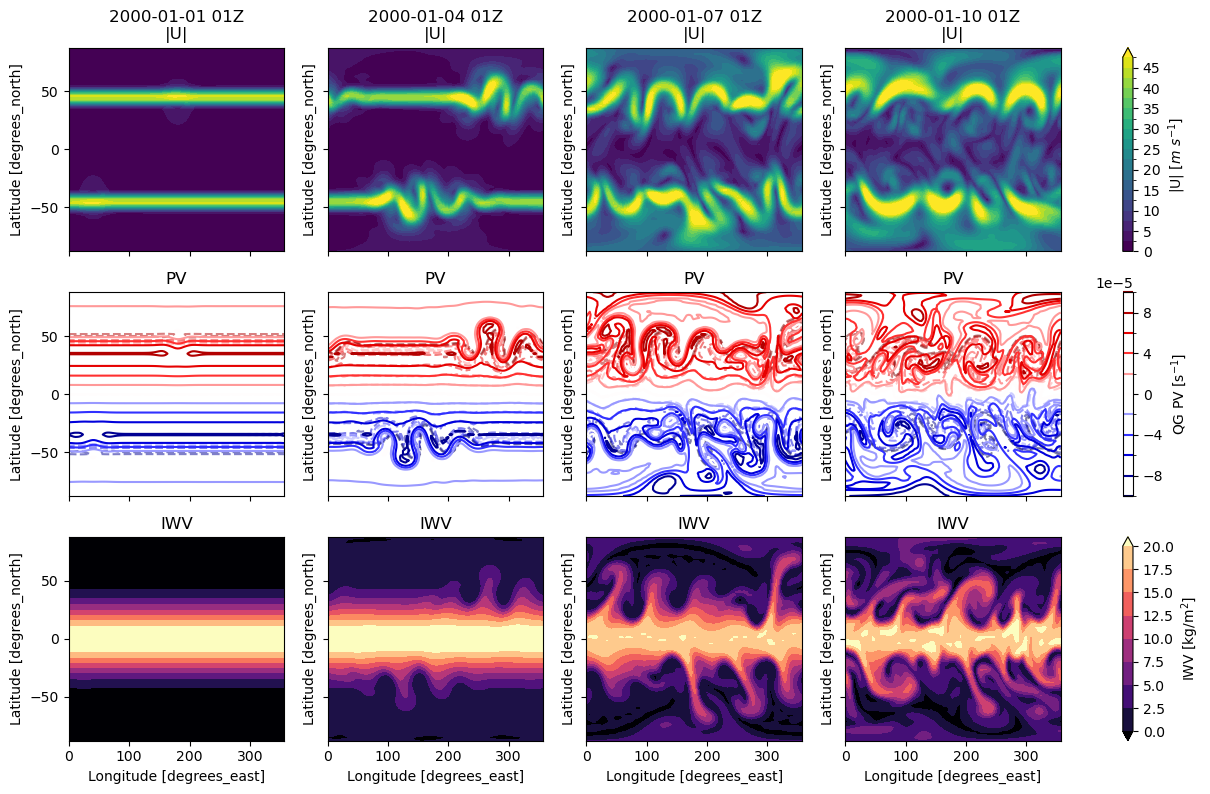

In [5]:
""" Generate several snapshots of PV and the height anomalies. """

# set the times for the snapshots
model_start = dt.datetime(2000, 1, 1, 1, 0, 0)
snapshot_times = [model_start + dt.timedelta(days = 3*i) for i in range(4)]



# set up the figure
fig, axs = plt.subplots(3, 4, figsize = (16, 9), sharex = True, sharey = True)

cplt = 3*[None]
levels = 3*[None]
linestyles = ['--', '-']
alphas = [0.5, 1]

# open the output file
with xr.open_dataset("output.qg_two_layer.2000-01-01-0000Z.nc", chunks = -1) as model_xr:
    # loop over the snapshot times
    for j, t in enumerate(snapshot_times):
        #*********************
        # Wind speed
        #*********************
        i = 0 # row index
        # set the levels to be the same in all plots
        if cplt[i] is not None:
            levels[i] = cplt[i].levels
        else:
            levels[i] = 20

        # loop over the layers
        cplt[i] = model_xr.UV.sel(time = t).mean(dim = "level").plot.contourf(
            ax = axs[i,j],
            levels = levels[i],
            cmap = "viridis",
            add_colorbar = False,
        )

        axs[i,j].set_title(t.strftime("%Y-%m-%d %HZ\n|U|"))
        axs[i,j].set_xlabel("")

        #*********************
        # potential vorticity
        #*********************
        i += 1 # row index
        # set the levels to be the same in all plots
        if cplt[i] is not None:
            levels[i] = cplt[i].levels
        else:
            levels[i] = 10

        # loop over the layers
        for l in [0,1]:
            cplt[i] = model_xr.PV.isel(level = l).squeeze().sel(time = t).plot.contour(
                ax = axs[i,j],
                levels = levels[i],
                cmap = "seismic",
                linestyles = linestyles[l],
                alpha = alphas[l],
            )

        axs[i,j].set_title(t.strftime("PV"))
        axs[i,j].set_xlabel("")

        #*********************
        # IWV
        #*********************
        i += 1 # row index
        # set the levels to be the same in all plots
        if cplt[i] is not None:
            levels[i] = cplt[i].levels
        else:
            levels[i] = 10

        # loop over the layers
        cplt[i] = model_xr.IWV.sel(time = t).sum(dim = "level").plot.contourf(
            ax = axs[i,j],
            levels = levels[i],
            cmap = "magma",
            add_colorbar = False,
        )

        axs[i,j].set_title("IWV")


# add colorbars
i = 0 
fig.colorbar(cplt[i], ax = axs[i,:].ravel(), orientation = "vertical", pad = 0.05, label = "|U| [$m$ $s^{-1}$]")
i += 1
fig.colorbar(cplt[i], ax = axs[i,:].ravel(), orientation = "vertical", pad = 0.05, label = "QG PV [s$^{-1}$]")
i += 1
fig.colorbar(cplt[i], ax = axs[i,:].ravel(), orientation = "vertical", pad = 0.05, label = "IWV [kg/m$^2$]")

# draw the plot
plt.show()


# Going further

Can you copy the code to run and plot the model into the cell below?

Consider trying a few modifications to see what happens:

* Make the model barotropic by setting `prop_shear = 1.0`
* Reduce the curvature in the jet by reducing its magnitude, and lowering the southern boundary (i.e., try `phi0 = np.pi/10`)
* Make the atmosphere less stable by decreasing `nsquar`
* Make the atmosphere more baroclinically unstable by reducing `prop_shear` toward zero
* Try setting your own initial condition!

In [6]:
""" Continue to play with the model here. """

' Continue to play with the model here. '

# Appendix: Derivation of the 2-layer QG model

Starting from the full 3D QG equation:

$$q = \nabla^2 \psi + f + \frac{\partial}{\partial z} \left( \frac{f_0^2}{N^2} \frac{\partial \psi}{\partial z} \right) $$

We consider discretizing the vertical coordinate into 5 levels of even thickness $\Delta h/2$: 0.5 (model top), 1, 1.5, 2, and 2.5 (model surface).  The height of the model is $H$.  The goal here is to derive an equation for PV on two levels, levels 1 and 2, corresponding to $q_1$ and $q_2$.  Five levels is the minimum possible needed because we have two height derivatives in the buoyancy/stretching term.

We apply a rigid-lid and rigid-surface boundary condition on the model, which is an excellent approximation for the surface and a not-terrible approximation for the tropopause.  There are two ways in which this boundary condition can manifest: (1) we can assert that the stability is infinitley high at these levels (i.e., $N^2_{0.5} = \infty$ and $N^2_{2.5} = \infty$), and (2) we can assert that $D(\partial \psi/\partial z)/Dt = 0$.  Either way it works out, the practical result is that we can simply use $\psi_{0.5} = 0$ and $\psi_{2.5} = 0$, even though that is not--strictly speaking--the appropriate boundary condition (the result ends up being the same).  We use second-order, centered finite differences to approximate the vertical derivatives.

For both levels (1) and (2), we need to know the buoyancy at level 1.5, which is:

$$ \frac{\partial \psi}{\partial z} \bigg|_{1.5} \approx \frac{\psi_1 - \psi_2}{\Delta h}\$$

For level 1, the buoyancy term is approximated as:

$$ \frac{\partial}{\partial z} \left( \frac{f_0^2}{N^2} \frac{\partial \psi}{\partial z} \right) \Biggr\rvert_1 \approx \frac{1}{\Delta h}\left[ \frac{f_0^2}{N^2_{0.5}} \frac{\partial \psi}{\partial z} \bigg|_{0.5} - \frac{f_0^2}{N^2_{1.5}} \frac{\partial \psi}{\partial z} \bigg|_{1.5}  \right]$$

Applying the rigid-lid boundary condition of $N^2_{0.5} = \infty$ sets the first term in the square brackets to 0, and we use the definition of $\partial \psi/\partial z$ at level 1.5 from above:


$$ \frac{1}{\Delta h}\left[ \frac{f_0^2}{N^2_{0.5}} \frac{\partial \psi}{\partial z} \bigg|_{0.5} - \frac{f_0^2}{N^2_{1.5}} \frac{\partial \psi}{\partial z} \bigg|_{1.5}  \right] = -\frac{f_0^2}{N^2_{1.5}}\frac{\psi_1 - \psi_2}{\Delta h^2} = \frac{f_0^2}{N^2_{1.5}}\frac{\psi_2 - \psi_1}{\Delta h^2} $$

With that the PV at level 1 is then:

$$q_1 = \nabla^2 \psi_1 + f + \frac{f_0^2}{N^2_{1.5} \Delta h^2}(\psi_2 - \psi_1)$$

If we apply the same mathematical reasoning to level 2--along with the rigid-surface boundary condition--we get a similar-looking equation:

$$q_2 = \nabla^2 \psi_2 + f + \frac{f_0^2}{N^2_{1.5} \Delta h^2}(\psi_1 - \psi_2)$$

## PV inversion

If we transform the two equations into spherical harmonics (e.g., $q_1 \to \tilde{q_1}$), the Laplacian can be rewritten as an algebraic coefficient $L_{mn}$, and the full equation can be written approximately as:

$$\tilde{q}_1 \approx  L_{mn} \tilde{\psi}_1 + \tilde{f} + \frac{f_0^2}{N^2_{1.5} \Delta h^2}(\tilde{\psi}_2 - \tilde{\psi}_1)$$
$$\tilde{q}_2 \approx  L_{mn} \tilde{\psi}_2 + \tilde{f} + \frac{f_0^2}{N^2_{1.5} \Delta h^2}(\tilde{\psi}_1 - \tilde{\psi}_2)$$

This is an approximation because the QG approximation on the sphere is only valid if we consider the full variation in $f^2$, which makes the spherical harmonic solution much more complicated (or one would need to use spheroidal harmonics as in Schubert et al. (2009) and Verkley (2009)).  Schubert et al. note that this approximation is good if the meridional scales of a given wave are not overly large and if $f_0$ is defined as its value at 45-degrees.  If we define $K \equiv f_0^2/(N_{1.5}^2 \Delta h^2)$, then the equations can be rewritten as:

$$\tilde{q}_1' = L_{mn}\tilde{\psi}_1 + K \tilde{\psi}_2 - K \tilde{\psi}_1$$
$$\tilde{q}_2' = L_{mn}\tilde{\psi}_2 + K \tilde{\psi}_1 - K \tilde{\psi}_2$$

or in matrix form as:

$$
\begin{pmatrix}
L_{mn}-K & K \\
K & L_{mn}-K
\end{pmatrix}
\begin{pmatrix}
\tilde{\psi}_1 \\
\tilde{\psi}_2 
\end{pmatrix}
=
\begin{pmatrix}
\tilde{q}_1' \\
\tilde{q}_2' 
\end{pmatrix}
$$

This has the solution:

$$
\begin{pmatrix}
\tilde{\psi}_1 \\
\tilde{\psi}_2 
\end{pmatrix}
=
\frac{1}{(L_{mn}-K)^2 - K^2}
\begin{pmatrix}
L_{mn} - K & -K \\
-K & L_{mn} - K
\end{pmatrix}
\begin{pmatrix}
\tilde{q}_1' \\
\tilde{q}_2' 
\end{pmatrix}
$$

or

$$
\tilde{\psi}_1 = \frac{(L_{mn} - K)\tilde{q}_1' - K \tilde{q}_2'}{(L_{mn}-K)^2 - K^2}
$$

$$
\tilde{\psi}_2 = \frac{(L_{mn} - K)\tilde{q}_2' - K \tilde{q}_1'}{(L_{mn}-K)^2 - K^2}
$$



## References
Schubert, W. H., Taft, R. K., & Silvers, L. G. (2009). Shallow Water Quasi-Geostrophic Theory on the Sphere. Journal of Advances in Modeling Earth Systems, 1(2), n/a-n/a. https://doi.org/10.3894/james.2009.1.2

Verkley, W. T. M. (2009). A balanced approximation of the one-layer shallow-water equations on a sphere. Journal of the Atmospheric Sciences, 66(6), 1735–1748. https://doi.org/10.1175/2008JAS2837.1